### Introduction

Hidden Markov Models (HMM) are a statistical tool used to predict the likelihood of a sequence of outcomes that depend on an unkown hidden state. We are interested in estimating the Value at Risk (VaR) of a portfolio where the growth of said portfolio follows a HMM.

Quantum computers offer two distinct advantages over classical algorithms for this application. Reference [1] shows that a Quantum Hidden Markov Model (QHMM) can use fewer model parameters than a HMM to capture equally complex behavior. Once the QHMM model is trained, a quantum computer can calculate the VaR with a quadratic speedup over classical Monte Carlo methods via Quantum Amplitude Estimation (QAE) [2].

The existing QHMM implementations like [3] utilize mid-circuit measurement, which means that the distribution they produce is not unitary and thus cannot be used in an estimation with QAE. Additionally, our implementation differs from the literature in that we treat the initial state of the system as its own trainable parameter. This means that the learned transition circuit can be repeated for an arbitrary number of time steps without the need to retrain the ansatz.

This notebook provides an example usage of the TrainableQHMM class, which is a tool that crates a QHMM with mid-circuit measurement and the trainable initial state structure. The class also creates a unitary circuit that is compatible with QAE using the trained circuit.

References:
1. Monras, A., Beige, A., & Wiesner, K. (2010). Hidden quantum Markov models and non-adaptive read-out of many-body states arXiv preprint arXiv:1002.2337.
1. Egger, D. J., Gutiérrez, R. G., Mestre, J. C., & Woerner, S. (2020). Credit risk analysis using quantum computers. IEEE Transactions on Computers, 70(12), 2136-2145.
1.  Markov, V., Rastunkov, V., Deshmukh, A., Fry, D., & Stefanski, C. (2022). Implementation and learning of quantum hidden markov models. arXiv preprint arXiv:2212.03796.

First, we need to choose a distribution or data set for our model to learn. In a practical implementation we would use real world data. For example, if we are intereseted in the Value at Risk of a portfolio of corporate bonds, we would begin by looking at historical data for said bonds, and grouping the daily log growths into one of 2 different categories. Classically, we use a Hidden Markov Model (HMM) to predict the probability of each sequence of growths.

For this example, we train our Quantum Hidden Markov Model (QHMM) with data generated by a HMM. We use a classical model with 4 hidden states and 2 emission states for a total of 20 parameters - 3 transition probabilities and 2 emission probabilities per hidden state. We will track distributions over 4 time steps.

In [12]:
from QHMM_AE import ClassicalHMM

num_time_steps = 4

transition_matrix = np.array([
        [0.5, 0.1, 0.15, 0.25],
        [0.1, 0.5, 0.25, 0.15],
        [0.25, 0.15, 0.5, 0.1],
        [0.15, 0.25, 0.1, 0.5]
        ])

emission_matrix = np.array([
        [0.8, 0.2],
        [0.2, 0.8],
        [0.4, 0.6],
        [0.6, 0.4]
    ])

initial_probabilities = np.array([0.25, 0.25, 0.25, 0.25])

hmm = ClassicalHMM(transition_matrix=transition_matrix,
                   emission_matrix=emission_matrix,
                   initial_probabilities=initial_probabilities,
                   )

target = hmm.generate_distribution(num_samples=1000,
                                   num_time_steps=num_time_steps)

Next we define the components of the QHMM circuit to train. For this we need one circuit to prepare the initial state of the distribution, and a parameterized ansatz circuit to learn the transition and emission behavior. The initial state circuit can also be learned depending on the application.

In [13]:
from qiskit.circuit.library import RealAmplitudes

num_qubits = 2

initial_state = RealAmplitudes(num_qubits=1,
                               entanglement='linear',
                               parameter_prefix='Phi',
                               reps=0
                               )


ansatz = RealAmplitudes(num_qubits=num_qubits,
                      entanglement='linear',
                      parameter_prefix='theta',
                      reps=0,
                      )

With our components defined, we can now initilize our TrainableHQMM circuit. We will measure the final qubit at each time step to determine the emitted state.

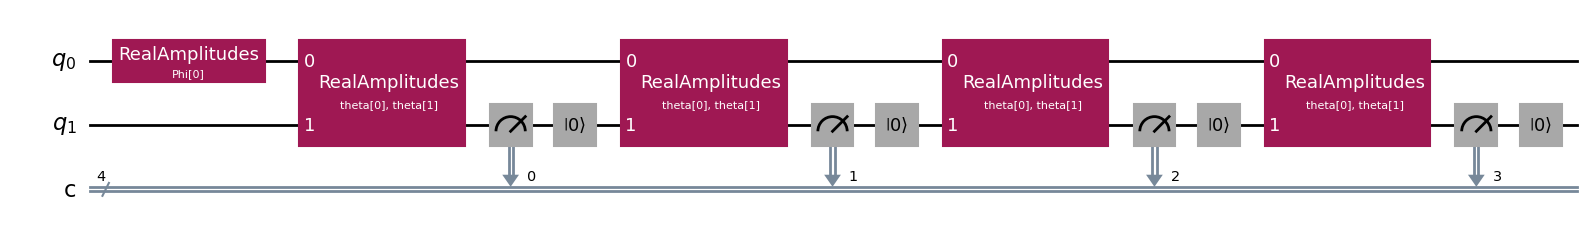

In [14]:
from QHMM_AE import TrainableHQMM

qhmm = TrainableHQMM(initial_state=initial_state,
                    ansatz=ansatz,
                    measurement_qubits=[-1],
                    num_time_steps=4,
                    )
qhmm.draw('mpl')

We need to define the optimizer and cost function in order to train the circuit. We follow [3] by using the Nelder-Mead optimizer and $ Cost = \sum_i (p_i^{target}-p_i^{current})^2 $ for all sequences $i.$  

In [15]:
from qiskit_algorithms.optimizers import NELDER_MEAD

optimizer = NELDER_MEAD(maxiter=100)

def cost_function(target: dict, 
                  current: dict):
    ''' 
    This function calculates the cost based on the MSE of the generated distribution and the target distribution. 
    The keys of the target and current dictionaries must be in the same format, however the probabilites/counts will be normalized.
    Args:
        target: dictionary with the sequence as the keys and the target counts or likelihood as the values.
        current: dictionary with the sequence as the keys and the generated counts or likelihood as the values.

    Returns:
        The squared error of the distributions.
    '''
    cost = 0
    # calculate the total number of counts/ probability to normalize the distributions
    total_current = sum(current.values())
    total_target = sum(target.values())

    # for sequence in either group of keys
    for sequence in set(target.keys()).union(current.keys()):

        # Normalize the probability of the sequence. If it does not exist set it to 0
        pt = target.get(sequence,0)/total_target
        pc = current.get(sequence, 0)/total_current

        # add the squared error of the cost
        cost += len(sequence)*((pt - pc)**2)
        

    return cost

The scipy Nelder-Mead optimizer needs an objective function that inputs a numpy array and outputs the cost. We need a qiskit runtime session to be active before defining such an objective function in order to include all of our circuit submissions in the same batch. Rather than re-defining our objective function inside of each session, lets define a "generate_objective_function" function, that can be called in one line within our runtime session. This function has an additional purpose in that it records the cost of each evaluation of the circuit so that we can plot the curve once training is complete.

In [23]:
# Create list outside of the objective function to record training curves in lieu of a callback function
cost_list = []

def generate_objective_function(sampler: Sampler,
                                target: dict,
                                circuit: QuantumCircuit,
                                n_shots: int = 1000):
    '''
    This function creates the objective function that can be optimized by the scipy optimizer.
    
    Args:
        sampler: QiskitRuntime Sampler V2 to be used to execute the dynamic circuit.
        target: The target distribution used to calculate the cost.
        circuit: The parametized quantum circuit to be optimized.
        n_shots: Number of shots the sampler should use to run each pass of the circuit.

    Returns
        A callablle that inputs an array of parameters and outputs the cost.
    '''
    # reset cost lost
    cost_list.clear()

    def objective_function(params) -> float:
        '''
        Function to be called by the minimizer during training.
        Args:
            params: A list or array of float parameters. The length must match the number of
                Parameters in circuit.
        Returns:
            The cost of the run as a float.
        ''' 
        # run circuit
        result = sampler.run([(circuit, params)], shots=n_shots).result()[0].data['c'].get_counts()

        # calculate cost
        cost = cost_function(target, result)

        # append to cost list
        cost_list.append(cost)

        return cost

    return objective_function

We are now ready to train our circuit. Let's generate initial parameter values, and train the circuit inside a Runtime Session. Sampling noise will interfere with the training process.

In [42]:
import numpy as np
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2 as Sampler
from qiskit import transpile
from qiskit_aer import AerSimulator

simulator = AerSimulator()
service = QiskitRuntimeService()

In [43]:
# set parameters and bounds
initial_params = np.random.uniform(0, 8*np.pi, qhmm.num_parameters)
bounds = [(0, 8*np.pi) for _ in initial_params]
n_shots = 1000

# create session and train circuit
with Session(backend=simulator) as session:
    sampler = Sampler(session=session)
    transpiled = transpile(qhmm, simulator)
    objective_function = generate_objective_function(sampler=sampler,
                                                     target=target,
                                                     circuit=transpiled,
                                                     n_shots=n_shots)

    result = optimizer.minimize(fun = objective_function,
                   x0 = initial_params,
                   bounds = bounds)
final_params = result.x
print(result)

c:\Users\19899\anaconda3\envs\QHMM\lib\site-packages\qiskit_ibm_runtime\session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


{   'fun': 0.0033280000000000015,
    'jac': None,
    'nfev': 259,
    'nit': 100,
    'njev': None,
    'x': array([13.96120148, 16.37109865, 14.11972986])}


Let's see how the training curve evolved over time.

final cost:  0.006792000000000002


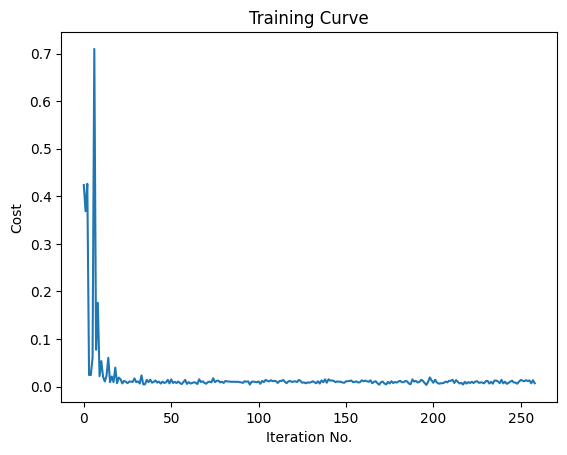

In [44]:
import matplotlib.pyplot as plt

plt.plot(cost_list)
plt.title('Training Curve')
plt.xlabel('Iteration No.')
plt.ylabel('Cost')
print('final cost: ', cost_list[-1])
plt.show()

Let's rerun the experiment with the trained parameters to see the learned sequence distribution. Note the high sampling noise in the distribution. For a more accurate distribution, we can re-run the training cell with n_shots = 10000 at the cost of a longer runtime. 

c:\Users\19899\anaconda3\envs\QHMM\lib\site-packages\qiskit_ibm_runtime\session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


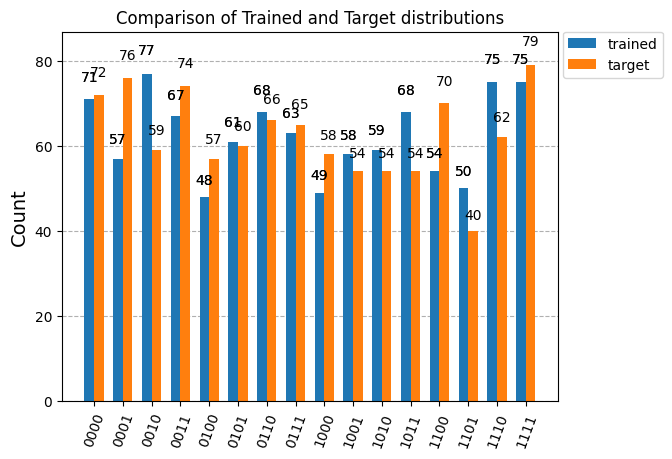

In [45]:
from qiskit.visualization import plot_histogram

with Session(backend=simulator) as session:
    sampler = Sampler(session=session)
    test_result = sampler.run([(transpiled, final_params)], shots=n_shots).result()[0]

plot_histogram([test_result.data['c'].get_counts(), target], 
               legend=['trained', 'target'],
               title='Comparison of Trained and Target distributions',
               )

With our Markov model trained, we can now use Amplitude Estimation to estimate the VaR with a quadratic speedup. To do so, we need to define a processing circuit that encodes the confidence onto the |1> amplitude of an objective qubit based on the emission probabilities, log returns foer each emitted state, and the loss we want to compare the value of the portfolio to.

The VarCircuit function from QHMM_AE creates a circuit to do just that. Lets create one and see its components.

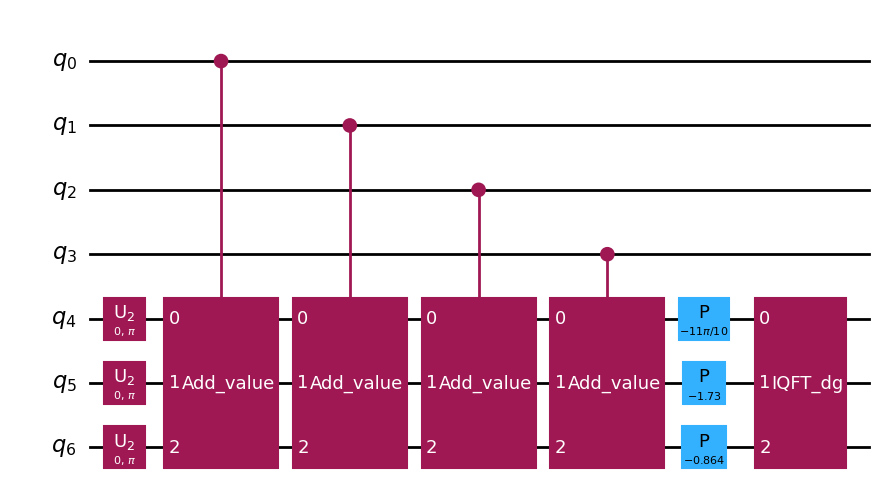

In [46]:
from QHMM_AE import VarCircuit

loss = 0.3 # the value we want to compare to.
growths = [0.0, 0.25] # the log growth of the portfolio for one time step in each state.
num_eval_qubits = 5
num_val_qubits = 3 # The number of qubits with which we want to store the value of the portfolio. 
var_circuit = VarCircuit(num_time_steps = num_time_steps, 
              growths=growths, 
              loss = loss, 
              num_val_qubits= num_val_qubits,
              insert_barriers=False)
var_circuit.decompose(reps=1).draw('mpl')

Next lets use the "to_state_prep" method of our TrainableQHMM instance. This combines the trained ansatz and value at risk circuit to create a Gate that encodes the likelihood of the portfolio loss exceeding the specified value in the amplitude of the objective qubit. It returns a tuple of the circuit, and the index of said objective qubit.

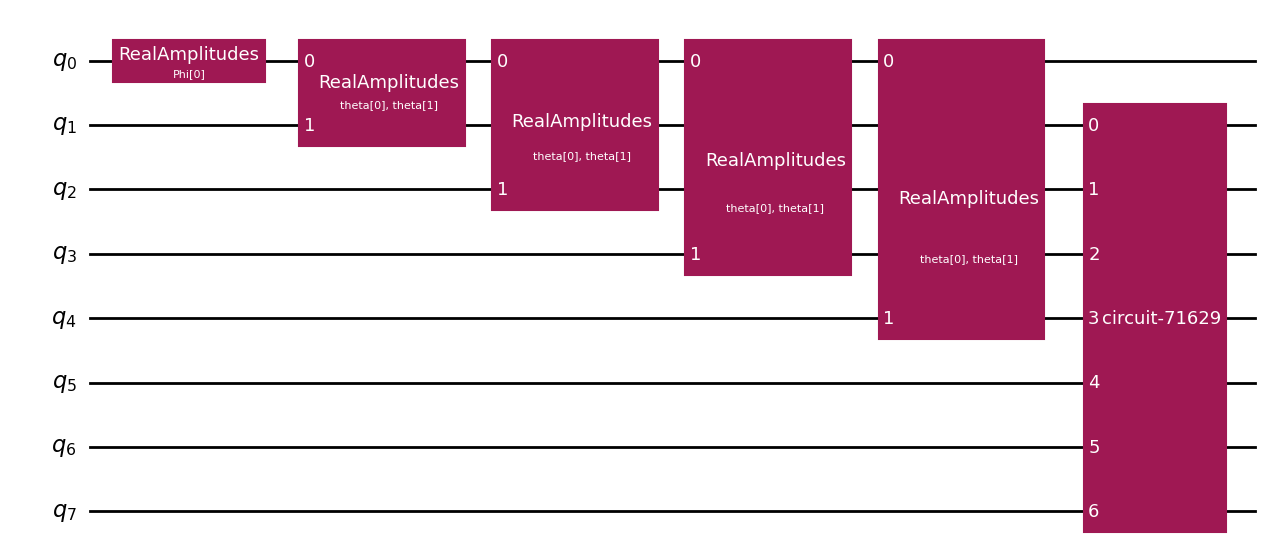

In [47]:
state_prep, objective_qubit = qhmm.to_state_prep(var_circuit.to_gate(), objective=var_circuit.num_qubits-1)

state_prep.assign_parameters(final_params)
state_prep.draw('mpl')

Now we have everything we need to use qiskit's Amplitude Estimation algorithm.

In [48]:
from qiskit_algorithms import AmplitudeEstimation, EstimationProblem
from qiskit.primitives import Sampler as sampler1

# bind the parameters with the trained values.
bound_state_prep = state_prep.assign_parameters(final_params)

problem = EstimationProblem(state_preparation = bound_state_prep,
                            objective_qubits = [bound_state_prep.num_qubits-1],
                            )

with Session(backend=simulator, service=service) as session:
    sampler = sampler1()

    ae = AmplitudeEstimation(num_eval_qubits = num_eval_qubits,
                            sampler = sampler)
    
    ae_circuit = ae.construct_circuit(problem)

    ae_result = ae.estimate(problem)

print('Result with QAE: ', ae_result.estimation)
print('MLE based on circuit results: ', ae_result.mle)

c:\Users\19899\anaconda3\envs\QHMM\lib\site-packages\qiskit_ibm_runtime\session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


Result with QAE:  0.3086583
MLE based on circuit results:  0.27066817483039185


Recall that in lieu of real world data, we are assuming that the process can be perfectly modeled by a HMM with 20 parameters. Let's generate the true credit risk for this example.

In [53]:
from QHMM_AE import ClassicalVaR

ideal_result = ClassicalVaR(hmm=hmm,
             num_time_steps=num_time_steps,
             growths=growths,
             num_samples=1000,
             loss=loss)

print('True value:', ideal_result)

True value: 0.344
